In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import os
from scipy.signal import filtfilt, stft, istft, remez, freqz

In [ ]:
levels = [
    {"noise": "levl 1.wav", "noisy": "suara + lvl 1.wav", "title": "Level 1 – Kipas Pelan"},
    {"noise": "levl 2.wav", "noisy": "suara + lvl 2.wav", "title": "Level 2 – Kipas Sedang"},
    {"noise": "levl 3.wav", "noisy": "suara + lvl 3.wav", "title": "Level 3 – Kipas Kencang"},
]

nperseg = 2048
noverlap = nperseg * 3 // 4
alpha = 15.0
beta = 0.008

# Simpan semua hasil di sini
all_results = []

print("SEDANG MEMPROSES 3 LEVEL...")

for idx, lvl in enumerate(levels, 1):
    print(f"\n[{idx}/3] Memproses: {lvl['title']}")

    # Load file
    fs1, noise_raw = wavfile.read(lvl["noise"])
    fs2, noisy_raw = wavfile.read(lvl["noisy"])
    fs = fs1  # pakai fs dari noise (pasti sama)

    if noise_raw.ndim > 1: noise_raw = noise_raw[:,0]
    if noisy_raw.ndim > 1: noisy_raw = noisy_raw[:,0]

    noise = noise_raw.astype(float) / np.max(np.abs(noise_raw))
    noisy = noisy_raw.astype(float) / np.max(np.abs(noisy_raw))

    # STFT + Spectral Subtraction
    f, t, Zxx_n = stft(noise, fs=fs, nperseg=nperseg, noverlap=noverlap)
    power_noise = np.mean(np.abs(Zxx_n)**2, axis=1)

    f, t, Zxx_s = stft(noisy, fs=fs, nperseg=nperseg, noverlap=noverlap)
    mag_s = np.abs(Zxx_s)
    phase_s = np.angle(Zxx_s)

    mag2_clean = mag_s**2 - alpha * power_noise[:, None]
    mag2_clean = np.maximum(mag2_clean, beta * mag_s**2)
    mag_clean = np.sqrt(mag2_clean)

    Zxx_clean = mag_clean * np.exp(1j * phase_s)
    _, clean_ss = istft(Zxx_clean, fs=fs, noverlap=noverlap, nperseg=nperseg)
    clean_ss = clean_ss[:len(noisy)]  # fix panjang


    filename = f"clean_{lvl['title'].replace(' – ', '_').replace(' ', '_')}.wav"
    wavfile.write(filename, fs, np.int16(clean_ss * 32767))
    print(f"   File audio disimpan: {filename}")

    # Simpan hasil untuk waveform
    all_results.append({
        'noisy_raw': noisy_raw,
        'clean_ss': clean_ss,
        'title': lvl['title'],
        'fs': fs
    })

    print(f"   Selesai {lvl['title']}!")

SEDANG MEMPROSES 3 LEVEL...

[1/3] Memproses: Level 1 – Kipas Pelan
   File audio disimpan: clean_Level_1_Kipas_Pelan.wav
   Selesai Level 1 – Kipas Pelan!

[2/3] Memproses: Level 2 – Kipas Sedang
   File audio disimpan: clean_Level_2_Kipas_Sedang.wav
   Selesai Level 2 – Kipas Sedang!

[3/3] Memproses: Level 3 – Kipas Kencang
   File audio disimpan: clean_Level_3_Kipas_Kencang.wav
   Selesai Level 3 – Kipas Kencang!


TAMPILKAN WAVEFORM BEFORE vs AFTER (detik 2.0 – 10.0)


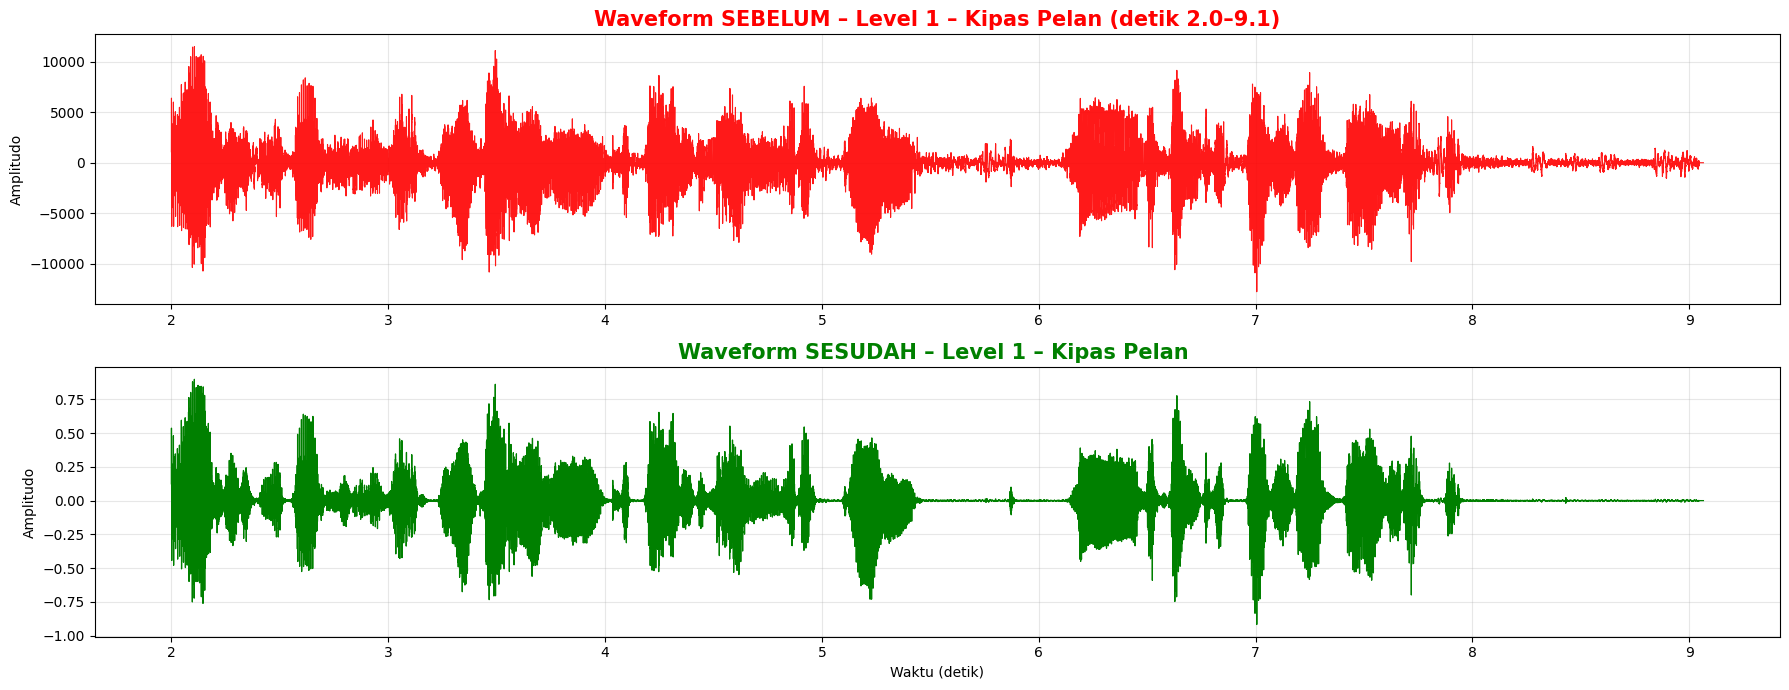

Grafik Level 1 – Kipas Pelan (8 detik) selesai ditampilkan!



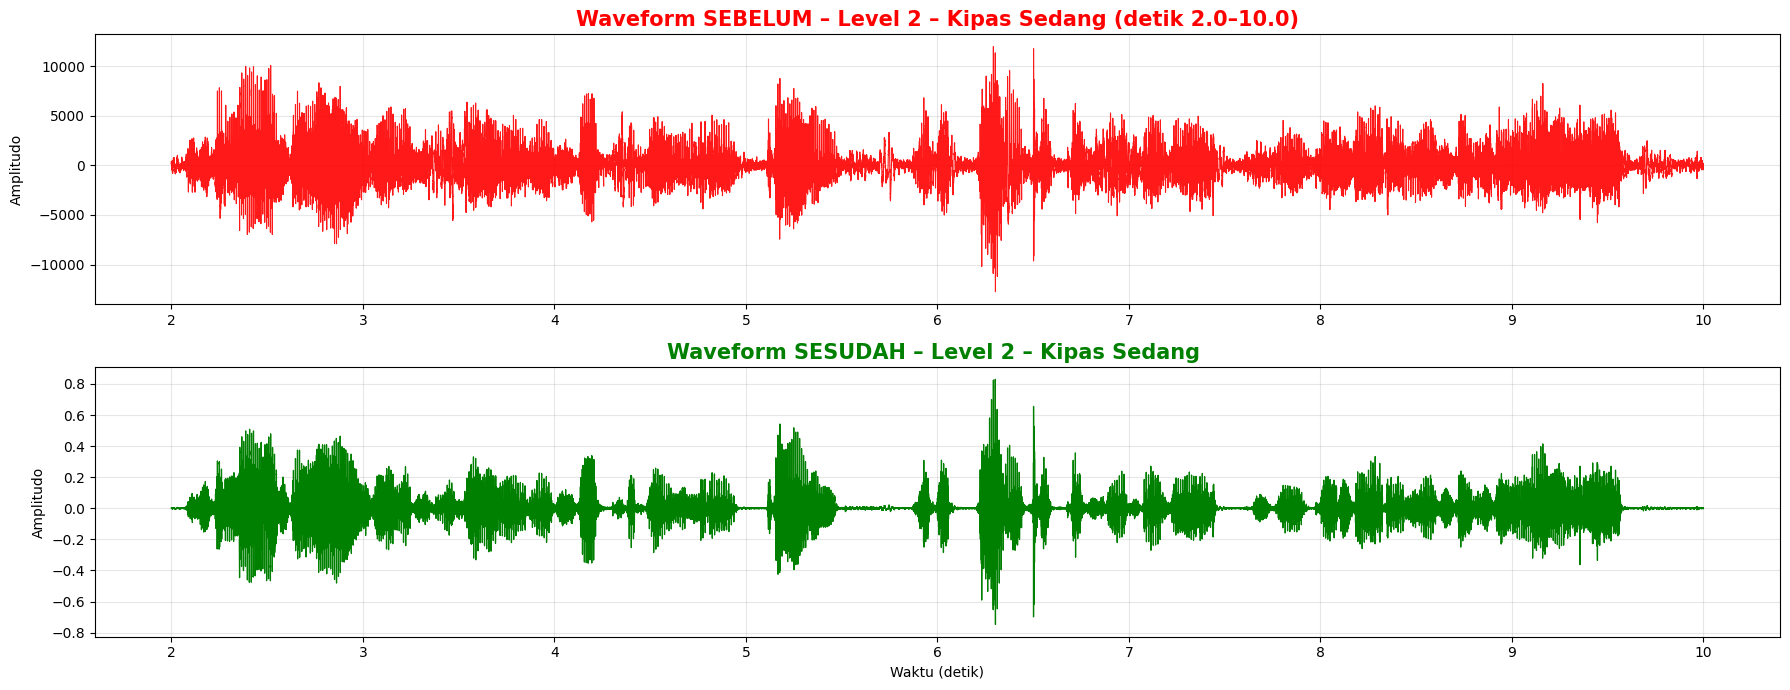

Grafik Level 2 – Kipas Sedang (8 detik) selesai ditampilkan!



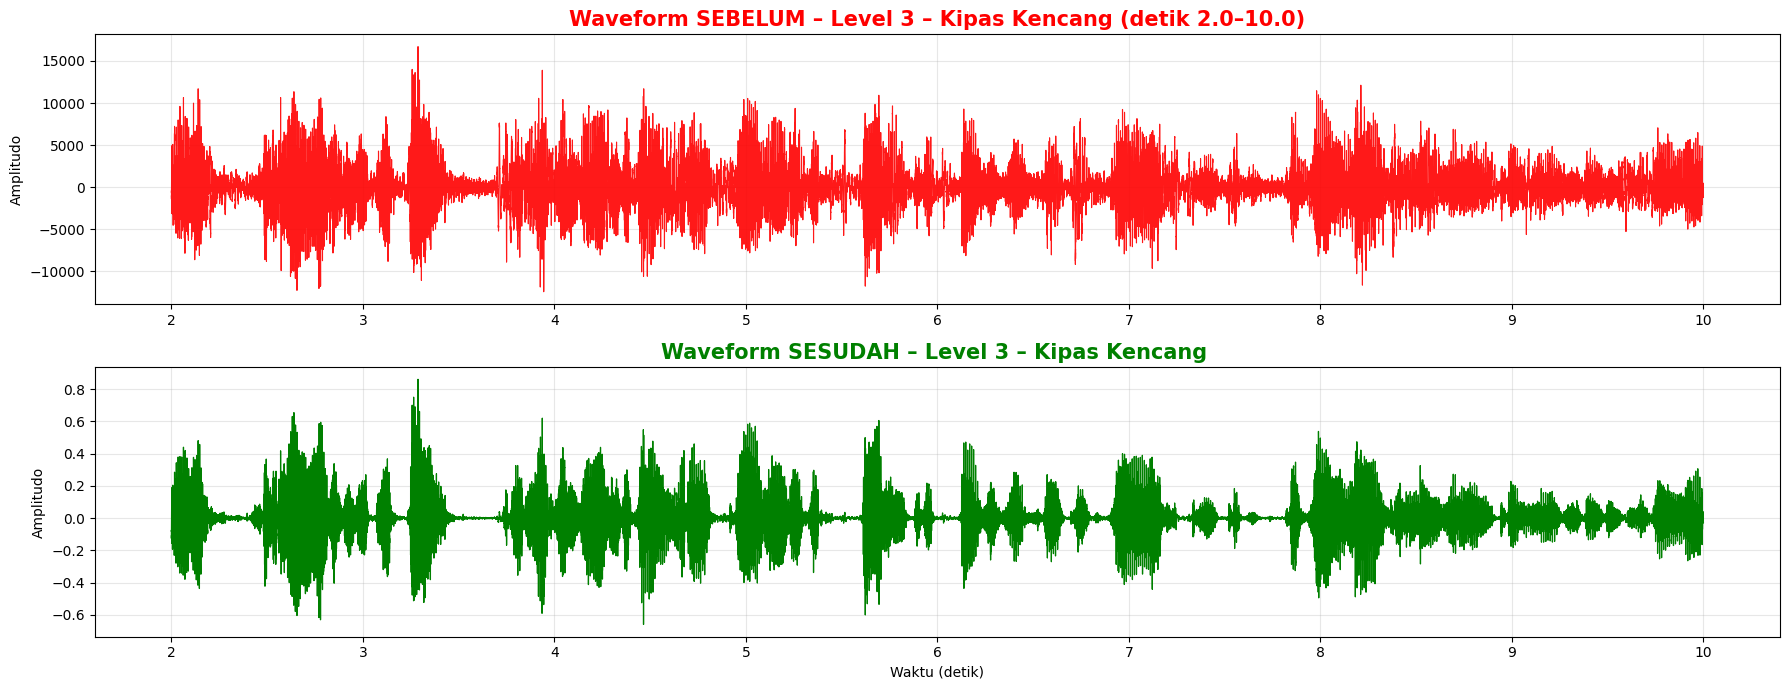

Grafik Level 3 – Kipas Kencang (8 detik) selesai ditampilkan!

SELESAI! 3 waveform panjang (8 detik) sudah muncul!


In [ ]:
print("TAMPILKAN WAVEFORM BEFORE vs AFTER (detik 2.0 – 10.0)")

for data in all_results:
    # ZOOM DARI DETIK KE-2 SAMPAI DETIK KE-10 (8 detik)
    start_sec = 2.0
    end_sec   = 10.0

    start = int(start_sec * data['fs'])
    end   = int(end_sec   * data['fs'])

    # Antisipasi kalau file lebih pendek dari 10 detik
    if end > len(data['noisy_raw']):
        end = len(data['noisy_raw'])
        end_sec = len(data['noisy_raw']) / data['fs']

    t = np.linspace(start_sec, end_sec, end - start)

    plt.figure(figsize=(18,7))  # lebih lebar biar 8 detik kelihatan jelas

    plt.subplot(2,1,1)
    plt.plot(t, data['noisy_raw'][start:end], 'r', alpha=0.9, linewidth=0.8)
    plt.title(f"Waveform SEBELUM – {data['title']} (detik {start_sec}–{end_sec:.1f})",
              fontsize=15, weight='bold', color='red')
    plt.ylabel("Amplitudo")
    plt.grid(alpha=0.3)

    plt.subplot(2,1,2)
    plt.plot(t, data['clean_ss'][start:end], 'g', linewidth=0.9)
    plt.title(f"Waveform SESUDAH – {data['title']} ",
              fontsize=15, weight='bold', color='green')
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Grafik {data['title']} (8 detik) selesai ditampilkan!\n")

print("SELESAI! 3 waveform panjang (8 detik) sudah muncul!")

FIR

MEMPROSES 3 LEVEL DENGAN FIR NOTCH FILTER (IMPROVED)

[1/3] Memproses: Level 1 – Kipas Pelan
   → Mendeteksi harmonik kipas...
   → Harmonik terdeteksi: ['49.8', '85.0', '143.6', '178.7', '222.7', '257.8', '304.7', '389.6'] Hz
   → Membuat filter dengan 8 notch...
   → Aplikasikan zero-phase filtering...
   ✓ File disimpan: clean_fir_Level_1_Kipas_Pelan.wav
   ✓ Level 1 – Kipas Pelan SELESAI!

[2/3] Memproses: Level 2 – Kipas Sedang
   → Mendeteksi harmonik kipas...
   → Harmonik terdeteksi: ['35.2', '82.0', '128.9', '161.1', '210.9', '263.7', '298.8', '363.3'] Hz
   → Membuat filter dengan 8 notch...
   → Aplikasikan zero-phase filtering...
   ✓ File disimpan: clean_fir_Level_2_Kipas_Sedang.wav
   ✓ Level 2 – Kipas Sedang SELESAI!

[3/3] Memproses: Level 3 – Kipas Kencang
   → Mendeteksi harmonik kipas...
   → Harmonik terdeteksi: ['52.7', '93.8', '126.0', '175.8', '219.7', '252.0', '301.8', '489.3'] Hz
   → Membuat filter dengan 8 notch...
   → Aplikasikan zero-phase filtering...
   

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

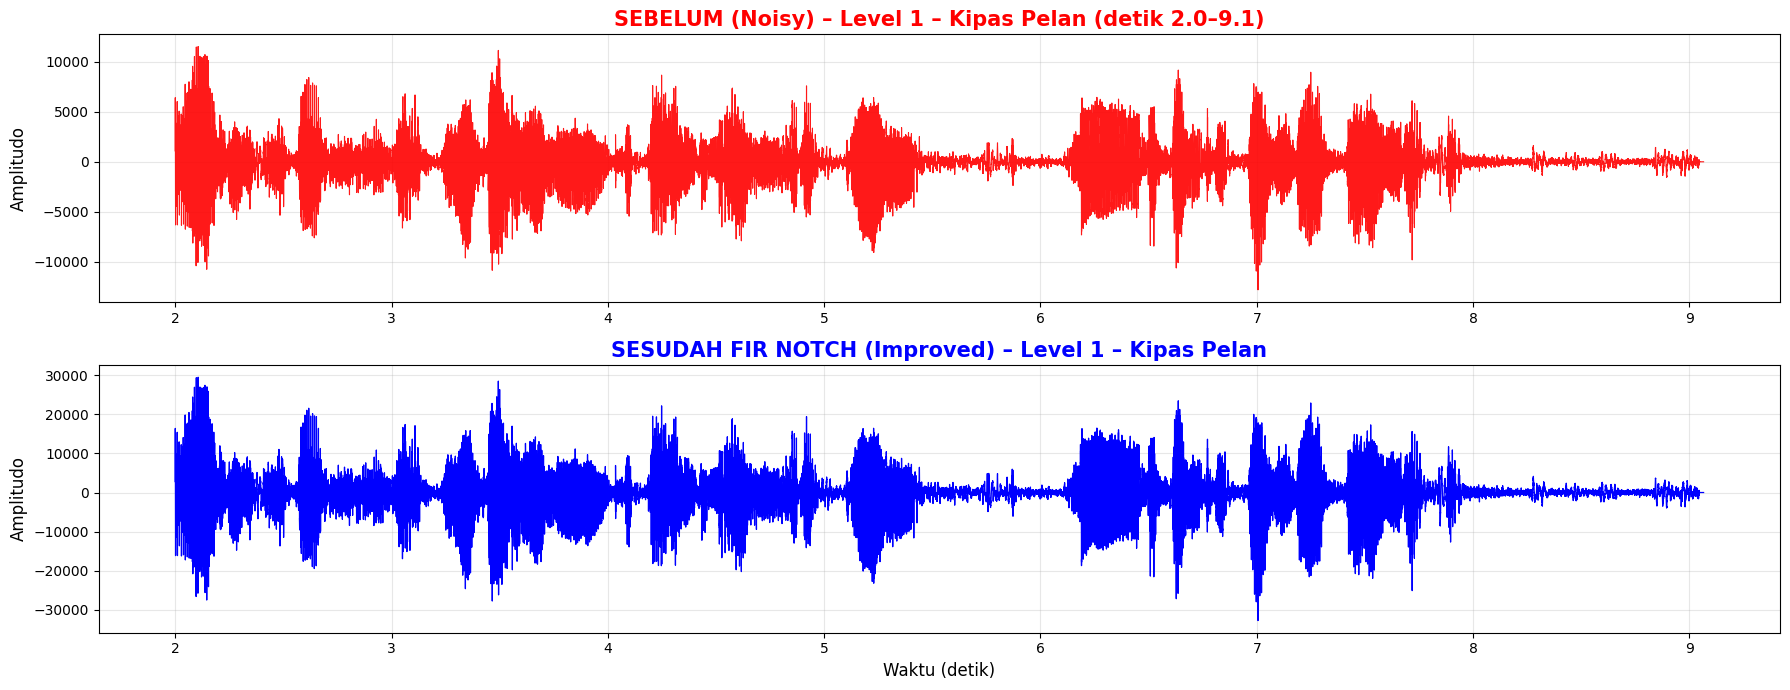

✓ Grafik Level 1 – Kipas Pelan selesai!



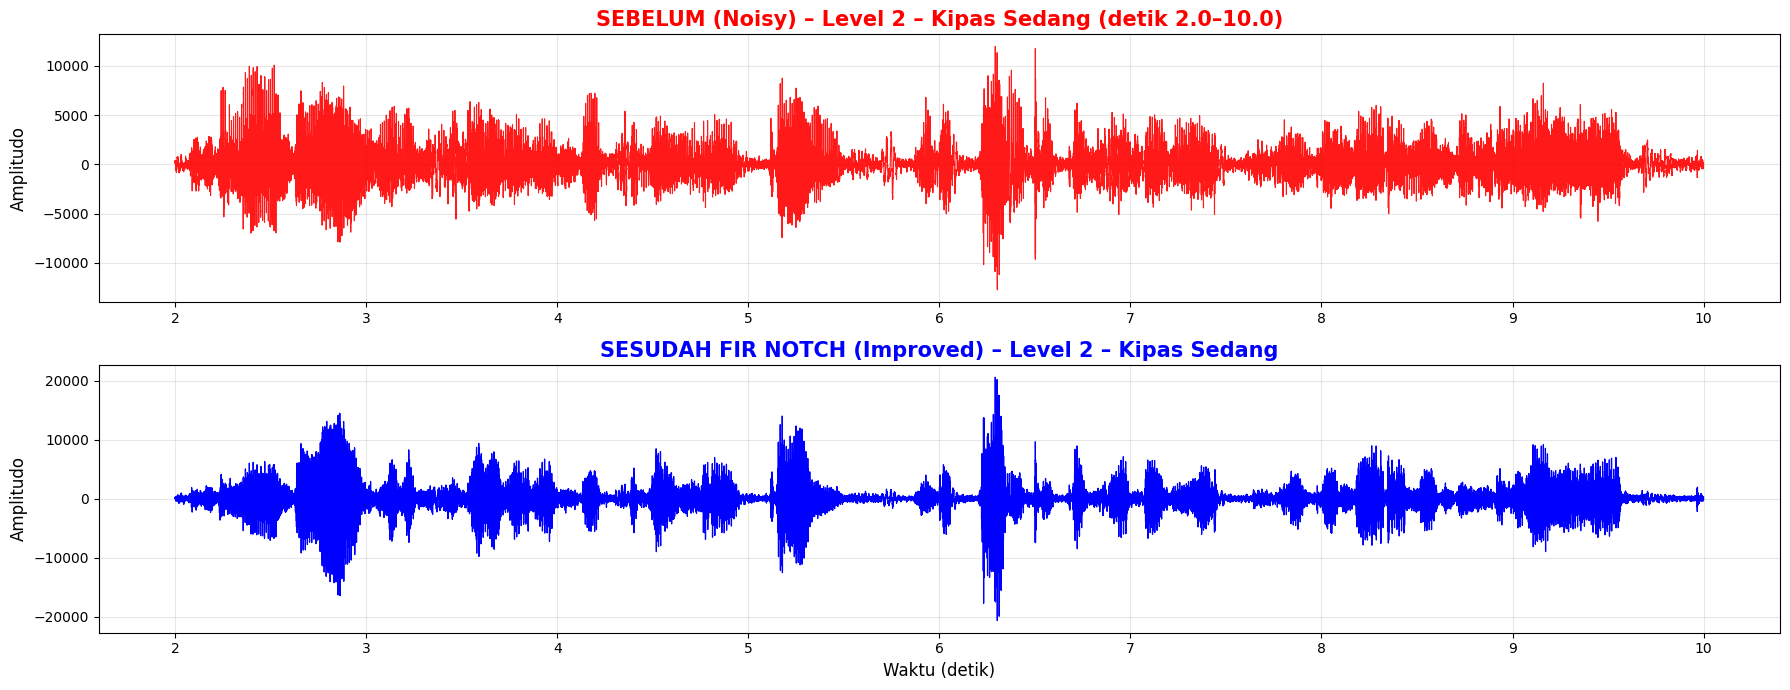

✓ Grafik Level 2 – Kipas Sedang selesai!



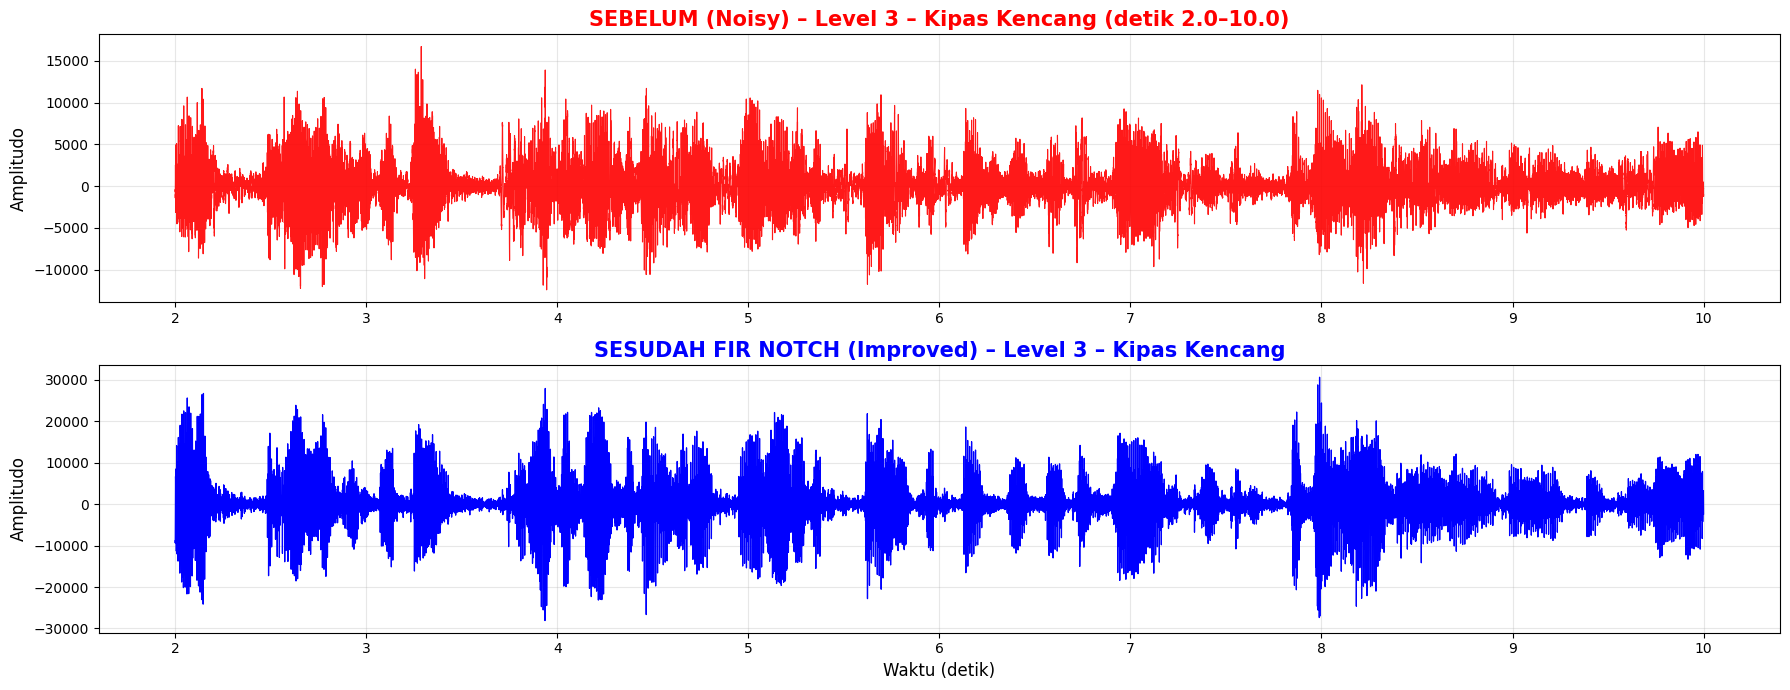

✓ Grafik Level 3 – Kipas Kencang selesai!

SELESAI! SEMUA VISUALISASI DITAMPILKAN!


In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import firwin, filtfilt, freqz
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Daftar level
levels = [
    {"noise": "levl 1.wav", "noisy": "suara + lvl 1.wav", "title": "Level 1 – Kipas Pelan"},
    {"noise": "levl 2.wav", "noisy": "suara + lvl 2.wav", "title": "Level 2 – Kipas Sedang"},
    {"noise": "levl 3.wav", "noisy": "suara + lvl 3.wav", "title": "Level 3 – Kipas Kencang"},
]

# Parameter untuk FIR Notch Filter (DIPERBAIKI)
num_taps = 201  # Lebih panjang untuk notch lebih tajam
notch_bandwidth = 10  # Bandwidth dalam Hz (bukan relatif) - lebih sempit
num_harmonics = 8  # Jumlah harmonik yang akan di-notch

def detect_harmonics(noise_signal, fs, num_harmonics=8, fft_size=16384):
    """
    Deteksi frekuensi fundamental dan harmoniknya dari noise
    """
    # FFT dengan resolusi tinggi
    yf = fft(noise_signal, n=fft_size)
    xf = fftfreq(fft_size, 1/fs)

    # Ambil frekuensi positif
    idx_pos = np.where((xf > 0) & (xf < fs/2))
    xf_pos = xf[idx_pos]
    yf_pos = np.abs(yf[idx_pos])

    # Cari peak frekuensi di range 20-500 Hz (range kipas)
    idx_range = np.where((xf_pos >= 20) & (xf_pos <= 500))[0]

    if len(idx_range) == 0:
        return [50, 100, 150, 200, 250]  # default jika gagal

    # Cari beberapa peak tertinggi
    peaks = []
    yf_range = yf_pos[idx_range].copy()
    xf_range = xf_pos[idx_range].copy()

    for _ in range(min(num_harmonics, 20)):
        if len(yf_range) == 0:
            break
        max_idx = np.argmax(yf_range)
        peak_freq = xf_range[max_idx]
        peaks.append(peak_freq)

        # Hapus frekuensi sekitar peak ini (±30 Hz) untuk cari peak berikutnya
        mask = np.abs(xf_range - peak_freq) > 30
        xf_range = xf_range[mask]
        yf_range = yf_range[mask]

    # Sort dan ambil num_harmonics pertama
    peaks = sorted(peaks)[:num_harmonics]

    return peaks

def design_multi_notch_fir(fs, notch_freqs, num_taps=201, bandwidth=10):
    """
    Desain FIR filter dengan multiple notch menggunakan frequency sampling method
    """
    if num_taps % 2 == 0:
        num_taps += 1

    # Buat frequency response yang diinginkan
    nfreqs = num_taps
    freqs = np.linspace(0, fs/2, nfreqs)
    desired = np.ones(nfreqs)

    # Set notch di setiap frekuensi target
    for notch_f in notch_freqs:
        # Cari index frekuensi terdekat
        for i, f in enumerate(freqs):
            if abs(f - notch_f) < bandwidth:
                # Gaussian window untuk transisi halus
                attenuation = np.exp(-((f - notch_f)**2) / (bandwidth/3)**2)
                desired[i] = attenuation

    # Inverse FFT untuk dapat impulse response
    # Mirror untuk buat symmetric (real-valued filter)
    desired_full = np.concatenate([desired, desired[-2:0:-1]])
    h = np.real(np.fft.ifft(desired_full))
    h = np.fft.fftshift(h)
    h = h[:num_taps]

    # Apply window
    window = np.hamming(num_taps)
    h = h * window

    # Normalisasi
    h = h / np.sum(h)

    return h

# Simpan semua hasil
all_results_fir = []

print("="*70)
print("MEMPROSES 3 LEVEL DENGAN FIR NOTCH FILTER (IMPROVED)")
print("="*70)

for idx, lvl in enumerate(levels, 1):
    print(f"\n[{idx}/3] Memproses: {lvl['title']}")

    # Load file
    fs1, noise_raw = wavfile.read(lvl["noise"])
    fs2, noisy_raw = wavfile.read(lvl["noisy"])
    fs = fs1

    if noise_raw.ndim > 1: noise_raw = noise_raw[:,0]
    if noisy_raw.ndim > 1: noisy_raw = noisy_raw[:,0]

    # Konversi ke float (JANGAN normalize dulu)
    noise = noise_raw.astype(float)
    noisy = noisy_raw.astype(float)

    # Step 1: Deteksi harmonik dari noise
    print(f"   → Mendeteksi harmonik kipas...")
    harmonics = detect_harmonics(noise, fs, num_harmonics=num_harmonics)
    print(f"   → Harmonik terdeteksi: {[f'{h:.1f}' for h in harmonics]} Hz")

    # Step 2: Desain Multi-Notch FIR Filter
    print(f"   → Membuat filter dengan {len(harmonics)} notch...")
    fir_coeff = design_multi_notch_fir(fs, harmonics, num_taps=num_taps, bandwidth=notch_bandwidth)

    # Step 3: Aplikasikan filter menggunakan filtfilt (zero-phase)
    print(f"   → Aplikasikan zero-phase filtering...")
    clean_fir = filtfilt(fir_coeff, 1.0, noisy)

    # Step 4: Normalisasi sekali saja di akhir
    max_val = np.max(np.abs(clean_fir))
    if max_val > 0:
        clean_fir_normalized = clean_fir / max_val
    else:
        clean_fir_normalized = clean_fir

    clean_fir_int = np.int16(clean_fir_normalized * 32767)

    # Simpan file audio
    filename = f"clean_fir_{lvl['title'].replace(' – ', '_').replace(' ', '_')}.wav"
    wavfile.write(filename, fs, clean_fir_int)
    print(f"   ✓ File disimpan: {filename}")

    # Simpan hasil untuk visualisasi
    all_results_fir.append({
        'noisy_raw': noisy_raw,
        'clean_fir': clean_fir_int,
        'title': lvl['title'],
        'fs': fs,
        'harmonics': harmonics,
        'fir_coeff': fir_coeff
    })

    print(f"   ✓ {lvl['title']} SELESAI!")

print("\n" + "="*70)
print("SELESAI MEMPROSES 3 LEVEL!")
print("="*70)

# ========== VISUALISASI FREQUENCY RESPONSE ==========
print("\nMENAMPILKAN FREQUENCY RESPONSE FILTER...")

for data in all_results_fir:
    w, h = freqz(data['fir_coeff'], worN=8000, fs=data['fs'])

    plt.figure(figsize=(16, 5))


# ========== VISUALISASI WAVEFORM ==========
print("\nMENAMPILKAN WAVEFORM BEFORE vs AFTER FIR (detik 2.0 – 10.0)...")

for data in all_results_fir:
    start_sec = 2.0
    end_sec = 10.0

    start = int(start_sec * data['fs'])
    end = int(end_sec * data['fs'])

    if end > len(data['noisy_raw']):
        end = len(data['noisy_raw'])
        end_sec = len(data['noisy_raw']) / data['fs']

    t = np.linspace(start_sec, end_sec, end - start)

    plt.figure(figsize=(18, 7))

    plt.subplot(2, 1, 1)
    plt.plot(t, data['noisy_raw'][start:end], 'r', alpha=0.9, linewidth=0.8)
    plt.title(f"SEBELUM (Noisy) – {data['title']} (detik {start_sec}–{end_sec:.1f})",
              fontsize=15, weight='bold', color='red')
    plt.ylabel("Amplitudo", fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(t, data['clean_fir'][start:end], 'b', linewidth=0.9)
    plt.title(f"SESUDAH FIR NOTCH (Improved) – {data['title']}",
              fontsize=15, weight='bold', color='blue')
    plt.xlabel("Waktu (detik)", fontsize=12)
    plt.ylabel("Amplitudo", fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"✓ Grafik {data['title']} selesai!\n")

print("="*70)
print("SELESAI! SEMUA VISUALISASI DITAMPILKAN!")
print("="*70)

MEMPROSES PERBANDINGAN KUANTITATIF FIR vs STFT...

Memproses: Level 1 – Kipas Pelan
   SNR Original: 11.42 dB
   SNR STFT: -2.32 dB (Improvement: -13.74 dB)
   MSE STFT: 5435838.1249
   SNR FIR: -3.65 dB (Improvement: -15.07 dB)
   MSE FIR: 7381682.3106

Memproses: Level 2 – Kipas Sedang
   SNR Original: 10.89 dB
   SNR STFT: 0.32 dB (Improvement: -10.58 dB)
   MSE STFT: 3052313.4533
   SNR FIR: -0.81 dB (Improvement: -11.70 dB)
   MSE FIR: 3952362.1212

Memproses: Level 3 – Kipas Kencang
   SNR Original: 5.33 dB
   SNR STFT: 1.43 dB (Improvement: -3.90 dB)
   MSE STFT: 5179814.3715
   SNR FIR: -2.67 dB (Improvement: -8.00 dB)
   MSE FIR: 13311820.9979

TABEL PERBANDINGAN KUANTITATIF:
Level                     SNR Orig (dB) SNR STFT (dB)  Improv STFT  MSE STFT   SNR FIR (dB)  Improv FIR  MSE FIR  
Level 1 – Kipas Pelan     11.42        -2.32          -13.74       5435838.1249 -3.65         -15.07      7381682.3106
Level 2 – Kipas Sedang    10.89        0.32           -10.58       30523

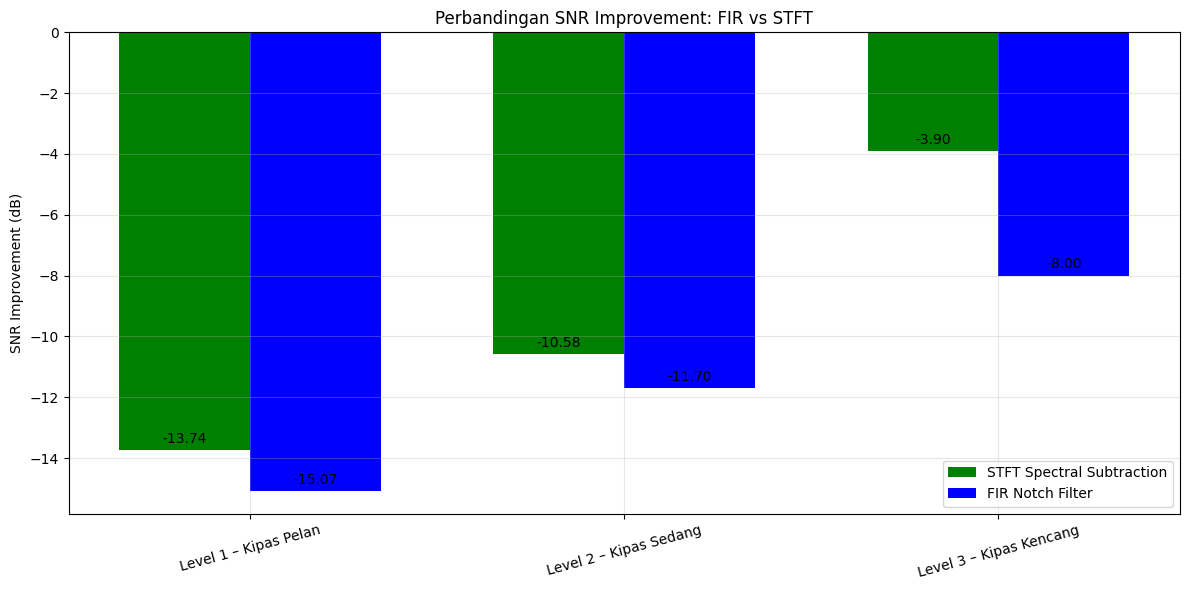


Bar chart SNR Improvement selesai ditampilkan!
SELESAI PERBANDINGAN KUANTITATIF!


In [ ]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Daftar level sama seperti sebelumnya
levels = [
    {"noise": "levl 1.wav", "noisy": "suara + lvl 1.wav", "title": "Level 1 – Kipas Pelan",
     "clean_stft": "clean_Level_1_Kipas_Pelan.wav", "clean_fir": "clean_fir_Level_1_Kipas_Pelan.wav"},
    {"noise": "levl 2.wav", "noisy": "suara + lvl 2.wav", "title": "Level 2 – Kipas Sedang",
     "clean_stft": "clean_Level_2_Kipas_Sedang.wav", "clean_fir": "clean_fir_Level_2_Kipas_Sedang.wav"},
    {"noise": "levl 3.wav", "noisy": "suara + lvl 3.wav", "title": "Level 3 – Kipas Kencang",
     "clean_stft": "clean_Level_3_Kipas_Kencang.wav", "clean_fir": "clean_fir_Level_3_Kipas_Kencang.wav"},
]

# Simpan hasil metrik
metrics = []

print("MEMPROSES PERBANDINGAN KUANTITATIF FIR vs STFT...")

for lvl in levels:
    print(f"\nMemproses: {lvl['title']}")

    # Load file raw
    fs_noise, noise_raw = wavfile.read(lvl["noise"])
    fs_noisy, noisy_raw = wavfile.read(lvl["noisy"])
    fs = fs_noise  # Pasti sama

    # Ambil channel pertama jika stereo
    if noise_raw.ndim > 1: noise_raw = noise_raw[:, 0]
    if noisy_raw.ndim > 1: noisy_raw = noisy_raw[:, 0]

    # Ensure both noise_raw and noisy_raw have the same length
    min_len_audio = min(len(noise_raw), len(noisy_raw))
    noise_raw = noise_raw[:min_len_audio]
    noisy_raw = noisy_raw[:min_len_audio]

    # Asumsikan noise aditif, estimasi ground truth clean
    clean_gt = noisy_raw.astype(float) - noise_raw.astype(float)

    # Hitung power untuk GT
    signal_power = np.mean(clean_gt ** 2)
    orig_noise_power = np.mean(noise_raw.astype(float) ** 2)
    if orig_noise_power == 0:
        snr_orig = float('inf')
    else:
        snr_orig = 10 * np.log10(signal_power / orig_noise_power)

    # Load clean STFT
    fs_stft, clean_stft_raw = wavfile.read(lvl["clean_stft"])
    if clean_stft_raw.ndim > 1: clean_stft_raw = clean_stft_raw[:, 0]
    clean_stft = clean_stft_raw.astype(float)

    # Pastikan panjang sama, potong jika perlu
    min_len = min(len(clean_gt), len(clean_stft))
    clean_gt_stft = clean_gt[:min_len]
    clean_stft = clean_stft[:min_len]

    # Hitung residual dan SNR untuk STFT
    residual_stft = clean_stft - clean_gt_stft
    residual_power_stft = np.mean(residual_stft ** 2)
    if residual_power_stft == 0:
        snr_stft = float('inf')
    else:
        snr_stft = 10 * np.log10(signal_power / residual_power_stft)
    mse_stft = np.mean(residual_stft ** 2)

    # Load clean FIR
    fs_fir, clean_fir_raw = wavfile.read(lvl["clean_fir"])
    if clean_fir_raw.ndim > 1: clean_fir_raw = clean_fir_raw[:, 0]
    clean_fir = clean_fir_raw.astype(float)

    # Pastikan panjang sama
    clean_gt_fir = clean_gt[:min_len]  # Gunakan min_len sama seperti STFT untuk konsistensi
    clean_fir = clean_fir[:min_len]

    # Hitung residual dan SNR untuk FIR
    residual_fir = clean_fir - clean_gt_fir
    residual_power_fir = np.mean(residual_fir ** 2)
    if residual_power_fir == 0:
        snr_fir = float('inf')
    else:
        snr_fir = 10 * np.log10(signal_power / residual_power_fir)
    mse_fir = np.mean(residual_fir ** 2)

    # Simpan metrik
    metrics.append({
        'title': lvl['title'],
        'snr_orig': snr_orig,
        'snr_stft': snr_stft,
        'mse_stft': mse_stft,
        'snr_fir': snr_fir,
        'mse_fir': mse_fir,
        'snr_improve_stft': snr_stft - snr_orig,
        'snr_improve_fir': snr_fir - snr_orig
    })

    print(f"   SNR Original: {snr_orig:.2f} dB")
    print(f"   SNR STFT: {snr_stft:.2f} dB (Improvement: {snr_stft - snr_orig:.2f} dB)")
    print(f"   MSE STFT: {mse_stft:.4f}")
    print(f"   SNR FIR: {snr_fir:.2f} dB (Improvement: {snr_fir - snr_orig:.2f} dB)")
    print(f"   MSE FIR: {mse_fir:.4f}")

# Tampilkan tabel perbandingan
print("\nTABEL PERBANDINGAN KUANTITATIF:")
print(f"{'Level':<25} {'SNR Orig (dB)':<12} {'SNR STFT (dB)':<14} {'Improv STFT':<12} {'MSE STFT':<10} {'SNR FIR (dB)':<13} {'Improv FIR':<11} {'MSE FIR':<9}")
for m in metrics:
    print(f"{m['title']:<25} {m['snr_orig']:<12.2f} {m['snr_stft']:<14.2f} {m['snr_improve_stft']:<12.2f} {m['mse_stft']:<10.4f} {m['snr_fir']:<13.2f} {m['snr_improve_fir']:<11.2f} {m['mse_fir']:<9.4f}")

# Visualisasi bar chart untuk SNR Improvement
titles = [m['title'] for m in metrics]
improv_stft = [m['snr_improve_stft'] for m in metrics]
improv_fir = [m['snr_improve_fir'] for m in metrics]

x = np.arange(len(titles))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, improv_stft, width, label='STFT Spectral Subtraction', color='g')
rects2 = ax.bar(x + width/2, improv_fir, width, label='FIR Notch Filter', color='b')

ax.set_ylabel('SNR Improvement (dB)')
ax.set_title('Perbandingan SNR Improvement: FIR vs STFT')
ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=15)
ax.legend()
ax.grid(alpha=0.3)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("\nBar chart SNR Improvement selesai ditampilkan!")
print("SELESAI PERBANDINGAN KUANTITATIF!")

In [ ]:
from IPython.display import Audio

In [ ]:
#before
Audio(filename='suara + lvl 3.wav', rate=48000)

In [ ]:
#before
Audio(filename='clean_Level_3_Kipas_Kencang.wav', rate=48000)